<H1>Mental Health Survey</H1>
The aim of this survey is to provide insights into to Mental Health and Tech industry.

In [1]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import textblob

In [2]:
sns.set(style='whitegrid')
sns.set_palette('mako')

<h2>Downloading data and shape of the datasets</h2>

In [3]:
cnx = sqlite3.connect(r'..\Module2\archive\mental_health.sqlite')
cursor = cnx.cursor()

cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

tables = cursor.fetchall()

for table in tables:
    print(table[0])

Answer
Question
Survey


Survey - a small explanation table, of SurveyID and a Description. This data set is not providing additional meaningful insight and will not be used.

In [4]:
question = pd.read_sql_query("SELECT * FROM Question", cnx)
answer_distribution = pd.read_sql_query("SELECT DISTINCT SurveyID, QuestionID FROM answer", cnx)

answer = pd.read_sql_query("""
                           SELECT 
                                AnswerText
                                ,SurveyID 
                                ,UserID
                                ,CASE 
                                    WHEN QuestionID = 1 THEN 'Age' 
                                    WHEN QuestionID = 2 THEN 'Gender'
                                    WHEN QuestionID = 3 THEN 'Living country' 
                                    WHEN QuestionID = 5 THEN 'Freelance' 
                                    WHEN QuestionID = 6 THEN 'Family history' 
                                    WHEN QuestionID = 89 THEN 'Race'
                                    ELSE QuestionID END AS QuestionID
                           FROM Answer
                           WHERE (QuestionID < 7) OR 
                                 (QuestionID BETWEEN 32 AND 34) OR 
                                 (QuestionID BETWEEN 48 AND 55) OR 
                                 (QuestionID IN (89)) OR 
                                 (QuestionID >114)
                        
                           """, cnx)

cnx.close()

In [5]:
def first_look(df):

    ### Capitalize column names ###
    df.columns = df.columns.astype(str).str.strip().str.capitalize()

    for i in df.columns:
        try:
            df[i] = df[i].astype(int)
        except:
            try:
                df[i] = df[i].astype(float)
            except:
                pass

    ### Performns initial data set analysis ###
    print(f'Column data types:\n{df.dtypes}\n')
    print(f'Dataset has {df.shape[0]} observations and {df.shape[1]} features')
    print(
        f'Columns with NULL values: {df.columns[df.isna().any()].tolist()}\n')

    ### Checking for unique values in columns ###
    for feature in df.columns:
        print(
            f'Column {feature} has unique values: {df[feature].unique().shape[0]}')


def dup_rows(df):
    ### Returns duplicated values ###
    print(f'Duplicated rows: {answer[answer.duplicated(keep=False)].shape[0]}')

    for feature in df.columns:
        print(
            f'Column {feature} has duplicated values: {df[df.duplicated(subset=[feature], keep=False)].shape[0]}')


def column_box_plot(df, feature):
    ### Box plot gragh for identifying numeric column outlier ###
    df.plot.box(figsize=(
        2, 3), title=f'{feature.capitalize()} ranges from {df[feature].min()} to {df[feature].max()}', y=[feature])


def column_duplicated(df):
    ### Returns duplicated values ###
    print(f'Duplicated rows: {answer[answer.duplicated(keep=False)].shape[0]}')

    for feature in df.columns:
        print(
            f'Column {feature} has duplicated values: {df[df.duplicated(subset=[feature], keep=False)].shape[0]}')


def empty_row_proc(df, feature):
    ### Empty Row persentage counting ###
    print(
        f'{feature} empty rows: {round(df[df[feature].isna()].shape[0] / df[feature].shape[0] * 100, 2)} %')

<h3>Answer_distribution</h3>
A currated dataset that shows with questions were available for each survey.

<h3>Answer</h3>
A set of questions that will be analyzed in the report. Some QuestionIDs are changed for most used questions.

<h3>Question</h3>
question table has 105 observations and 2 features, all unique:

* Questiontext
* Questionid

In [6]:
first_look(question)

Column data types:
Questiontext    object
Questionid       int32
dtype: object

Dataset has 105 observations and 2 features
Columns with NULL values: []

Column Questiontext has unique values: 105
Column Questionid has unique values: 105


In [7]:
column_duplicated(question)

Duplicated rows: 0
Column Questiontext has duplicated values: 0
Column Questionid has duplicated values: 0


<h3>Answer Distribution</h3>
Missing Questionid: 35-47. Surveys in 2017-2019 have the same set of questions, with 2017 having the most questions answered.

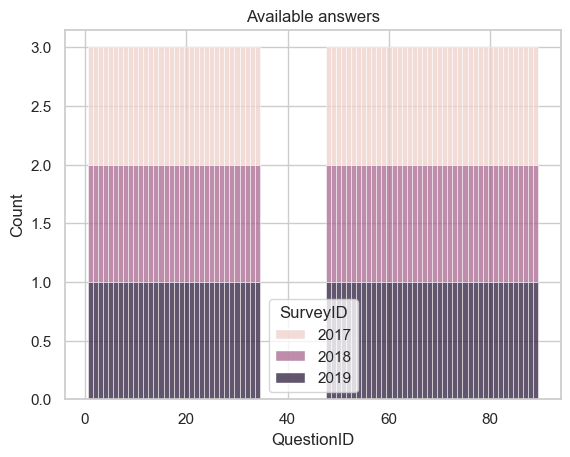

In [8]:
sns.histplot(data=answer_distribution[answer_distribution['SurveyID'] >= 2017],
             x="QuestionID", hue='SurveyID', multiple="stack", bins=36, discrete=True)
plt.title('Available answers');

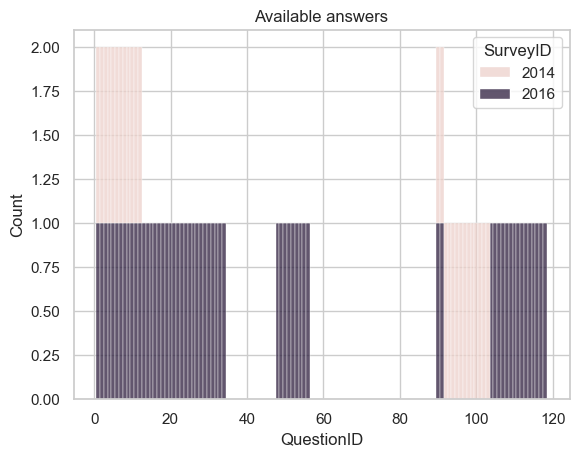

In [9]:
sns.histplot(data=answer_distribution[answer_distribution['SurveyID'] < 2017],
             x="QuestionID", hue='SurveyID', multiple="stack", bins=36, discrete=True)
plt.title('Available answers');

<h2>Cleaning Answer data set</h2>
-1 is notated as missing value instead of Null, missing answers are 23.89% of the whole survey.

In [10]:
answer['AnswerText'] = answer['AnswerText'].replace('-1', np.nan)

In [11]:
first_look(answer)

Column data types:
Answertext    object
Surveyid       int32
Userid         int32
Questionid    object
dtype: object

Dataset has 67361 observations and 4 features
Columns with NULL values: ['Answertext']

Column Answertext has unique values: 384
Column Surveyid has unique values: 5
Column Userid has unique values: 4218
Column Questionid has unique values: 22


Empty row count is 23.91%

In [12]:
round(answer[answer['Answertext'].isna()].shape[0] /
      answer['Answertext'].shape[0] * 100, 2)

23.91

<h3>Cleaning data on multiple choice answers and translating data</h3>
Users choices are categorized in multiple choice answers - for mental health diagnoses or job profile. Multiple choice questions are transformed to 'choice count' columns

In [13]:
### Cleaning diagnoses ###

answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower().str.contains(
    'social|depression|bipolar|seasonal affective|suicidal')), 'Answertext'] = 'Mood-Related'
answer.loc[(answer['Questionid'].isin([115, 116])) & (
    answer['Answertext'].str.lower().str.contains('anxiety')), 'Answertext'] = 'Anxiety'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower().str.contains(
    'burnout|burn out|stress response|post-traumatic|ptsd')), 'Answertext'] = 'Stress-Related'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower(
).str.contains('substance|addictive|sexual')), 'Answertext'] = 'Substance-Related'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower(
).str.contains('traumatic brain injury|sleeping ')), 'Answertext'] = 'Neurological and Sleep'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower(
).str.contains('autism|asperge|pdd|pervasive')), 'Answertext'] = 'Autism Spectrum'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower(
).str.contains('trans|gender')), 'Answertext'] = 'Gender Dysphoria'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower().str.contains(
    'attention deficit|adhd|add ')), 'Answertext'] = 'Attention Deficit Hyperactivity'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower().str.contains(
    'schizotypal')), 'Answertext'] = 'Psychotic (Schizophrenia, Schizoaffective, etc)'
answer.loc[(answer['Questionid'].isin([115, 116])) & (answer['Answertext'].str.lower(
).str.contains('dissociative|deperson')), 'Answertext'] = 'Dissociative'
answer.loc[(answer['Questionid'].isin([115, 116])) & (
    answer['Answertext'].str.lower().str.contains('tinnitus|hurt')), 'Answertext'] = np.nan


### Questions 115-117 can have multiple answers, in translational datase these will be represented as 'choice count' ###
work_position_count = answer[answer['Questionid'] == 117].groupby(['Userid'])[
    'Answertext'].count().reset_index().rename(columns={'Answertext': 'Work_position_count'})
believed_conditions = answer[answer['Questionid'] == 116].groupby(['Userid'])[
    'Answertext'].count().reset_index().rename(columns={'Answertext': 'Believed_conditions'})
diagnosed_conditions = answer[answer['Questionid'] == 115].groupby(['Userid'])[
    'Answertext'].count().reset_index().rename(columns={'Answertext': 'Diagnosed_conditions'})

Creating a translated dataset, whith QuestionIDs as Column names, instead of rows

In [14]:
### Values for questions 115-117 have been transformed to Work load and Mental Health disorder counts intead ###
curated_answer = answer[~answer['Questionid'].isin([115, 116, 117])].pivot(
    index=['Userid', 'Surveyid'], columns='Questionid', values='Answertext').reset_index()

### Adding the count columns ###
curated_answer = pd.merge(
    curated_answer, work_position_count, on='Userid', how='left')
curated_answer = pd.merge(
    curated_answer, believed_conditions, on='Userid', how='left')
curated_answer = pd.merge(
    curated_answer, diagnosed_conditions, on='Userid', how='left')

In [15]:
first_look(curated_answer)

Column data types:
Userid                    int32
Surveyid                  int32
4                        object
32                       object
33                       object
34                       object
48                       object
49                       object
50                       object
51                       object
52                       object
53                       object
54                       object
55                       object
118                      object
Age                     float64
Family history           object
Freelance               float64
Gender                   object
Living country           object
Race                     object
Work_position_count     float64
Believed_conditions     float64
Diagnosed_conditions    float64
dtype: object

Dataset has 4218 observations and 24 features
Columns with NULL values: ['4', '32', '33', '34', '48', '49', '50', '51', '52', '53', '54', '55', '118', 'Age', 'Freelance', 'Gender', 'Living country',

<h3>Prank answers</h3>
Age, Gender or Living Country is regarded as essential columns, each are missing up to 0.6% of answers.

In [16]:
empty_row_proc(curated_answer, 'Age')
empty_row_proc(curated_answer, 'Gender')
empty_row_proc(curated_answer, 'Living country')

Age empty rows: 0.12 %
Gender empty rows: 0.57 %
Living country empty rows: 0.05 %


Combination of missing answers is 0.64%. This is a small amount of rows and will be dropped.

In [17]:
good_rows = curated_answer[~curated_answer['Age'].isna(
) & ~curated_answer['Gender'].isna() & ~curated_answer['Living country'].isna()]

(1 - good_rows.shape[0]/curated_answer.shape[0]) * 100

0.6401137980085347

In [18]:
curated_answer = good_rows

del good_rows

<h1>Analyzing the answer demographic: Who is the main respondent to the Survey?</h1>
<h3>Age</h3> 
Age has 9 faulty age inputs - young children or people too old to be still working. These will be dropped.<br>

In [19]:
curated_answer[(curated_answer['Age'] > 90) |
               (curated_answer['Age'] < 16)]['Age']

143     -29.0
364     329.0
734       5.0
989       8.0
1090     11.0
1632     99.0
1824    323.0
1916      3.0
2068     15.0
3980      0.0
Name: Age, dtype: float64

In [20]:
curated_answer.loc[143, 'Age'] = 29
curated_answer = curated_answer[(
    curated_answer['Age'] < 90) & (curated_answer['Age'] > 16)]

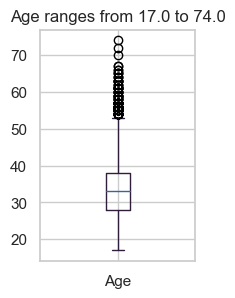

In [21]:
column_box_plot(curated_answer, 'Age')

The mean of the respondents age is 33.8 +/- 8 years.

In [22]:
curated_answer['Age'].describe()

count    4182.000000
mean       33.863702
std         8.068208
min        17.000000
25%        28.000000
50%        33.000000
75%        38.000000
max        74.000000
Name: Age, dtype: float64

<h3>Gender</h3>
Gender has 16 faulty gender inputs, these will be dropped. Response rates from genders are staggeringly different and analysis will be done on Genders separately to avoid bias.

In [23]:
curated_answer.loc[curated_answer['Gender'].str.lower() ==
                   'female', 'Gender'] = 'Female'
curated_answer.loc[curated_answer['Gender'].str.lower() ==
                   'male', 'Gender'] = 'Male'
curated_answer.loc[~curated_answer['Gender'].str.lower().isin(['female', 'male'])
                   & curated_answer['Gender'].str.lower().str.contains(
                       'fem|mtf|ftm|trans|demi|non|fluid|queer|andro|enby|nb|gender|male|guy|neuter|they|afab|iden|masc'
                       ), 'Gender'] = 'Non-binary'

Males are 3 times more represented in this survey. Weights could be added to equalize the impact of Male vs Female answers. This approach will not work for finding the differences between sexes, thus no weights will be added and analysis will be done separately.

In [24]:
curated_answer.groupby('Gender')['Gender'].count().sort_values(ascending=False).head()

Gender
Male           3035
Female         1024
Non-binary      107
Questioning       1
rr                1
Name: Gender, dtype: int64

Non-binary responses are 107 and it's too low of a number to derive any meaningful conclusions.

In [25]:
curated_answer = curated_answer[curated_answer['Gender'].isin(
    ['Female', 'Male'])]

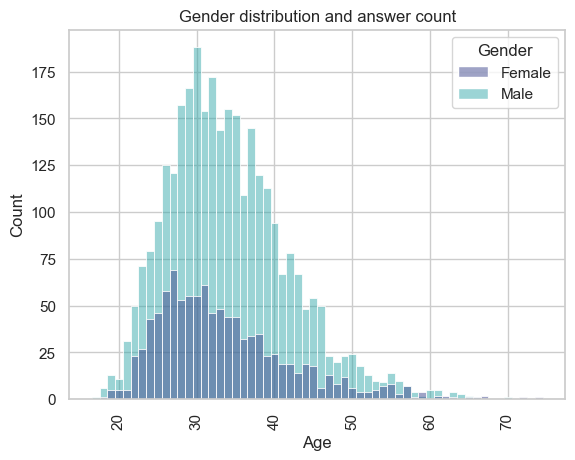

In [26]:
sns.histplot(data=curated_answer, hue='Gender', x='Age', palette='mako', discrete=True)
plt.xticks(rotation=90)
plt.title('Gender distribution and answer count');

<h3>Race</h3>
Race question was available only since 2017 and only 30% of respondents answered this question.<br>
What do I do with so much white people? According to article: https://mashable.com/article/diversity-report-silicon-valley-white-men
61.4% of Tech industry workers are white, while this survey has them at 88.48%.<br>
Due to insufficient data through the years and low response rate, race will not be used. However, it is clear that finding from this survey represents white people best.

In [27]:
empty_row_proc(curated_answer,'Race')

Race empty rows: 76.96 %


In [28]:
round(curated_answer[curated_answer["Race"] == 'White'].shape[0] /
      curated_answer[~curated_answer["Race"].isna()].shape[0] * 100, 2)

88.56

<h3>Living Country</h3>

In [29]:
curated_answer.loc[curated_answer['Living country'].str.lower(
) == 'united states', 'Living country'] = 'United States of America'

61% of respondents are living in United States of America, 11% - United Kingdom and 5% - Canada. This makes 77% of responses from the Western hemisphere. This survey best represents the Western world.

In [30]:
curated_answer.groupby('Living country')['Living country'].count().sort_values(
    ascending=False) .head(7) / curated_answer.shape[0] * 100

Living country
United States of America    61.961074
United Kingdom              11.357477
Canada                       4.508500
Germany                      3.202759
Netherlands                  2.291205
Australia                    1.798473
France                       1.256467
Name: Living country, dtype: float64

<h3>Job profile</h3>
Job profile was available only on 2016, but from it it's clear that 46% are people in either Back-end or Front-end Developing jobs, 14% are leaders.

46% are either Back-end or Front-end Developing jobs

In [31]:
answer[(answer['Questionid'] == 117) & answer['Answertext'].str.lower().str.contains(
    'developer')]['Answertext'].shape[0] / answer[(answer['Questionid'] == 117)].shape[0] * 100

46.02526002971768

14% are leaders

In [32]:
answer[(answer['Questionid'] == 117) & answer['Answertext'].str.lower().str.contains(
    'lead')]['Answertext'].shape[0] / answer[(answer['Questionid'] == 117)].shape[0] * 100

14.041604754829123

This survey mainly is focused on Developers and leaders, but not support, designers, sales, analysts or HR.

In [33]:
answer[answer['Questionid'] == 117].groupby('Answertext')['Answertext'].count().sort_values(ascending=False)

Answertext
Back-end Developer         737
Front-end Developer        502
DevOps/SysAdmin            282
Supervisor/Team Lead       277
Other                      187
Support                    168
One-person shop            161
Designer                   135
Executive Leadership       101
Dev Evangelist/Advocate     99
Sales                       31
HR                          12
Name: Answertext, dtype: int64

<h3>Self-Employment Status</h3>
Self employment - missing 0.43% from 2014. These values will be dropped.

In [34]:
empty_row_proc(curated_answer,'Freelance')

Freelance empty rows: 0.44 %


In [35]:
curated_answer[curated_answer['Freelance'].isna()]['Surveyid'].unique()

array([2014])

In [36]:
curated_answer = curated_answer[~curated_answer['Freelance'].isna()]

Freelancers are 15.76 of the Male respondents and 13.94% of Female respondents.

In [37]:
freelance = curated_answer.groupby(['Gender', 'Freelance']).size(
).unstack().reset_index().rename_axis(None, axis=1)
freelance['Proc'] = round(
    freelance[1.0] / (freelance[0.0] + freelance[1.0]) * 100, 2)
freelance

,Gender,0.0,1.0,Proc
0,Female,877,142,13.94
1,Male,2546,476,15.75


Freelances are older by a couple of years. This is expected as freelance work requires seniority in marketable skills.<br>
The respondents are mostly between 30-50 years old.

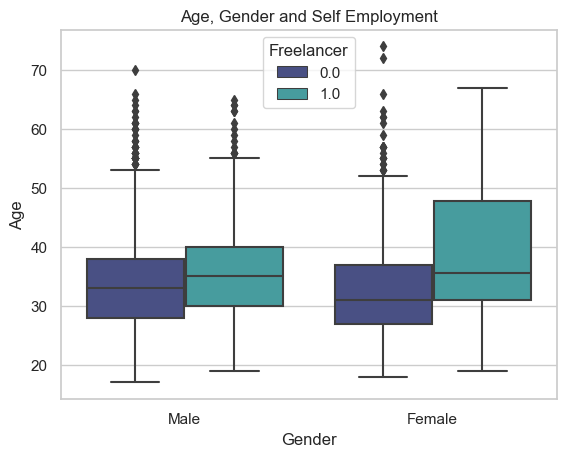

In [38]:
sns.boxplot(data=curated_answer, x="Gender", y="Age", hue='Freelance', palette='mako')
plt.legend(title="Freelancer")
plt.title('Age, Gender and Self Employment');

<h3>Family history</h3>

Interestingly, 57.7% Females noted they have Family history of Mental Illness, but 45.6% of Males said no. 15-20 % of respondents don't know their family history.

In [39]:
family_history = curated_answer.groupby(['Gender', 'Family history']).size(
).unstack().reset_index().rename_axis(None, axis=1)


for i, row in enumerate(family_history.columns):
    if i != 0:
        family_history[row+'_Proc'] = round(family_history[row] / (
            family_history['Yes'] + family_history['No'] + family_history["I don't know"]) * 100, 2)


family_history

,Gender,I don't know,No,Yes,I don't know_Proc,No_Proc,Yes_Proc
0,Female,156,275,588,15.31,26.99,57.70
1,Male,462,1379,1181,15.29,45.63,39.08


<h1>Diagnoses and Interference with Work among Genders</h1>
<h3>How many people were ever diagnosed with Mental Health issue?</h3>

In [40]:
def responce_proc(df, feature):
    ### Turning responce rates into Percentages###

    df = df.groupby(['Gender', 'Family history', feature]).size(
    ).unstack().reset_index().rename_axis(None, axis=1)

    for i, row in enumerate(df.columns):
        if i > 1:
            df[row+'_Proc'] = round(df[row] /
                                    df.sum(axis=1, numeric_only=True) * 100, 2)

    df = df.set_index(['Gender', 'Family history'])
    df = df[[col for col in df.columns if '_Proc' in col]]

    return df

In [41]:
diagnosis_time = pd.concat(
    [responce_proc(curated_answer, '34'),
     responce_proc(curated_answer, '32')[['No_Proc', 'Yes_Proc']],
     responce_proc(curated_answer, '33')[['No_Proc', 'Yes_Proc']]
     ], keys=['Ever diagnosed', 'Past disorder', 'Current disorder']).sort_values(by=['Gender', 'Family history']).reset_index().rename(columns={'level_0': 'Disorder Time'})

This survey shows Females are more diagnosed than Males (58.3% vs 51.9%.)

In [42]:
diagnosis_time[diagnosis_time['Disorder Time'] == 'Ever diagnosed'].groupby(
    ['Gender'])['Yes_Proc'].describe()[['mean', 'std']]

,mean,std
Gender,,
Female,58.310000,28.788713
Male,51.193333,22.255697


* People with Family history are more likely to be diagnosed.
* Comparing the numbers between past and current Mental Health issues, current numbers are slightly lower - could be that people see past as harder times.

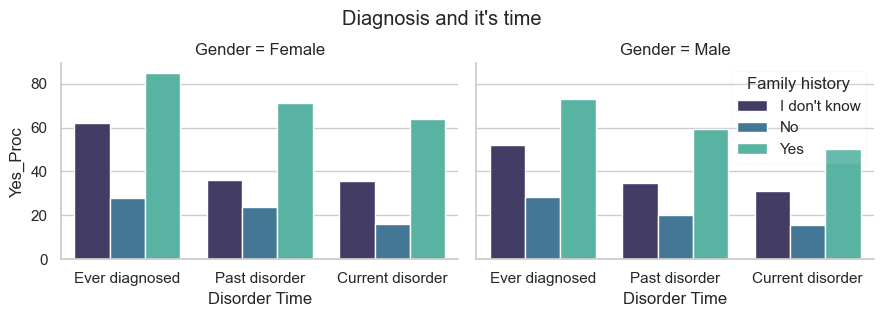

In [43]:
g = sns.FacetGrid(diagnosis_time, col="Gender", aspect=1.5,)
g.map_dataframe(sns.barplot, x='Disorder Time', y="Yes_Proc",
                hue='Family history', palette='mako')

g.fig.suptitle("Diagnosis and it's time", y=1.05)

plt.legend(title="Family history").get_frame().set_alpha(0.1);

<h3>Interference with Work in Performance and Productivity</h3>
<h4>Does having Mental Health Disorder Interference with Work: Managed vs Unmanaged conditions? </h4>
Answers in a subset of questions haves been transformed into scalar scale, with -2 being 'No' and +2 being 'Often'

In [44]:
def scalar_scale_5(df, feature):
    ### Turns string scale into scalar scale ###

    df.loc[curated_answer[feature].isin(
        ['Never', 'No, because it would impact me negatively']), feature] = -2
    df.loc[curated_answer[feature].isin(
        ['Rarely', "No, because it doesn't matter"]), feature] = -1
    df.loc[curated_answer[feature].isin(['Not applicable to me']), feature] = 0
    df.loc[curated_answer[feature].isin(
        ['Sometimes', 'Sometimes, if it comes up']), feature] = 1
    df.loc[curated_answer[feature].isin(['Often', 'Yes, always']), feature] = 2

In [45]:
scalar_scale_5(curated_answer, '48')
scalar_scale_5(curated_answer, '49')
first_look(curated_answer)

Column data types:
Userid                    int32
Surveyid                  int32
4                        object
32                       object
33                       object
34                       object
48                      float64
49                      float64
50                       object
51                       object
52                       object
53                       object
54                       object
55                       object
118                      object
Age                       int32
Family history           object
Freelance                 int32
Gender                   object
Living country           object
Race                     object
Work_position_count     float64
Believed_conditions     float64
Diagnosed_conditions    float64
dtype: object

Dataset has 4041 observations and 24 features
Columns with NULL values: ['4', '32', '33', '34', '48', '49', '50', '51', '52', '53', '54', '55', '118', 'Race', 'Work_position_count', 'Believed_condit

In [46]:
work_interference = curated_answer[['Gender', 'Family history', '48', '49']].dropna().groupby(['Gender', 'Family history'])[['48', '49']].describe(
).stack(level=0).reset_index().rename(columns={'level_2': 'Questions'})[['Gender', 'Family history', 'Questions', 'mean', 'std']]
work_interference.loc[work_interference['Questions']
                      == '48', 'Questions'] = 'Effective treatment'
work_interference.loc[work_interference['Questions']
                      == '49', 'Questions'] = 'Ineffective treatment'

Standard deviation is almost 1 point, meaning answers are variaing from 'Sometimes' to 'Ofter'

In [47]:
round(work_interference['std'].mean(), 2)

0.94

* Treated conditions don't interfere with Work.
* Females have higher average threshold of interference (when not treated) than Males.
* People with Family history have more trouble managing untreated conditions, it could be that their family memories add an additional layer of fear when experiencing mental health issues. Another reason might be the severity of illness, passed down genetically.

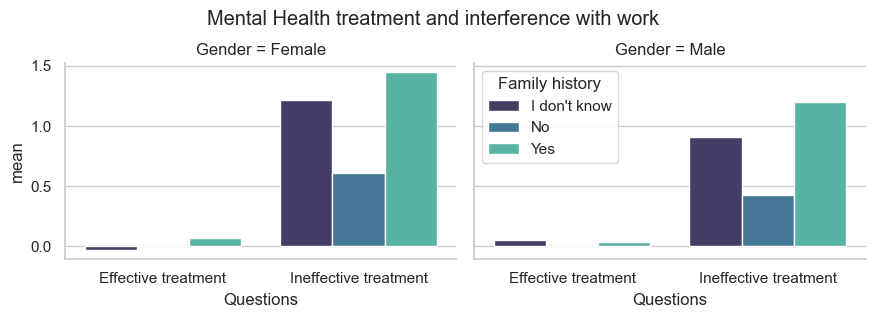

In [48]:
g = sns.FacetGrid(work_interference, col="Gender", aspect=1.5)
g.map_dataframe(sns.barplot, x="Questions", y="mean",
                hue='Family history', palette='mako')

g.fig.suptitle("Mental Health treatment and interference with work", y=1.05)

plt.legend(title="Family history");

<h4>Is productivity ever affected by a mental health issue?</h4>

In [49]:
productivity = responce_proc(curated_answer, '54').sort_values(
    by=['Gender', 'Family history']).reset_index()

Those with faimily history have a particularly hard time with productivity (> 80% Males and Females said that it has an impact).

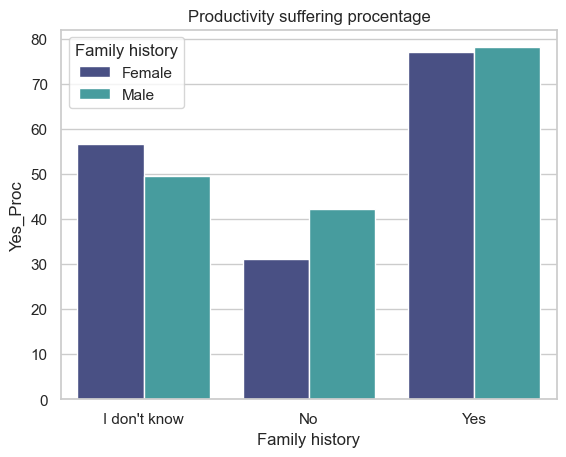

In [50]:
sns.barplot(productivity, x="Family history",
            y="Yes_Proc", hue='Gender', palette='mako')
plt.legend(title="Family history")
plt.title('Productivity suffering procentage');

In [51]:
productivity_proc = curated_answer[curated_answer['54'] == 'Yes'].dropna(how='all').groupby(
    ['Gender', 'Family history', '55'])['55'].count().to_frame().rename(columns={'55': 'Count of People affected'}).reset_index()

* Males suffer from productivity issues heavily.
* Females with family history in mental health suffer with productivity.

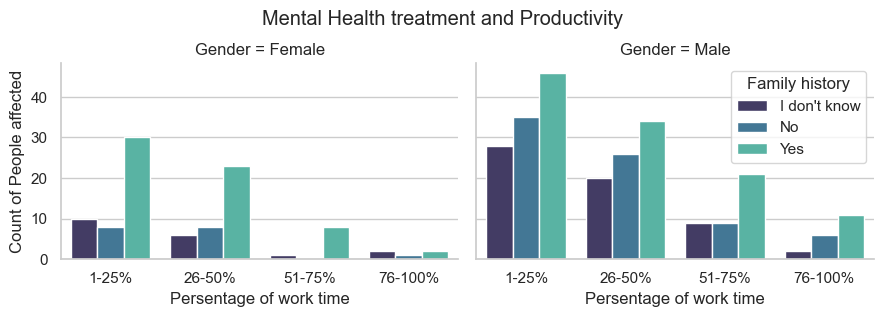

In [52]:
g = sns.FacetGrid(productivity_proc, col="Gender", aspect=1.5)
g.map_dataframe(sns.barplot, x="55", y='Count of People affected', hue='Family history', order=[
                '1-25%', '26-50%', '51-75%', '76-100%'], palette='mako')

g.fig.suptitle("Mental Health treatment and Productivity", y=1.05)
g.set_axis_labels("Persentage of work time")

plt.legend(title="Family history");

Looking at Productivity and Work Interference it is clear that people with Family history have a particularly hart time. Interestingly, Males productivity suffer, yet Females feel the overall Work performance suffer.

<h2>Mental Health Diagnosis and revealing it to Contacts</h2>
Respondents were asked, if they been diagnosed or treated for a mental health disorder and if they reveal this information to Contacts.
The scale was transformed to scalar, with -2 being "No, because it would impact me negatively" and +2 "Yes, always".

In [53]:
scalar_scale_5(curated_answer, '52')
scalar_scale_5(curated_answer, '53')

first_look(curated_answer);

Column data types:
Userid                    int32
Surveyid                  int32
4                        object
32                       object
33                       object
34                       object
48                      float64
49                      float64
50                       object
51                       object
52                      float64
53                      float64
54                       object
55                       object
118                      object
Age                       int32
Family history           object
Freelance                 int32
Gender                   object
Living country           object
Race                     object
Work_position_count     float64
Believed_conditions     float64
Diagnosed_conditions    float64
dtype: object

Dataset has 4041 observations and 24 features
Columns with NULL values: ['4', '32', '33', '34', '48', '49', '50', '51', '52', '53', '54', '55', '118', 'Race', 'Work_position_count', 'Believed_condit

In [54]:
revealing = curated_answer[['Gender', 'Family history', '52', '53']].dropna().groupby(['Gender', 'Family history'])[['52', '53']].describe(
).stack(level=0).reset_index().rename(columns={'level_2': 'Questions'})[['Gender', 'Family history', 'Questions', 'mean', 'std']]
revealing.loc[revealing['Questions'] == '52',
              'Questions'] = 'Clients/business contacts'
revealing.loc[revealing['Questions'] == '53',
              'Questions'] = 'Coworkers/employees'

The variability is 1.16 points

In [55]:
round(revealing['std'].mean(), 2)

1.16

* Males and Females would not reveal delicate information to business contacts
* Females with family history would strongly not reveal - this could indicate a fear of sexism in case of showed as weak.
* Males are generally less extreme on revealing info to Clients.

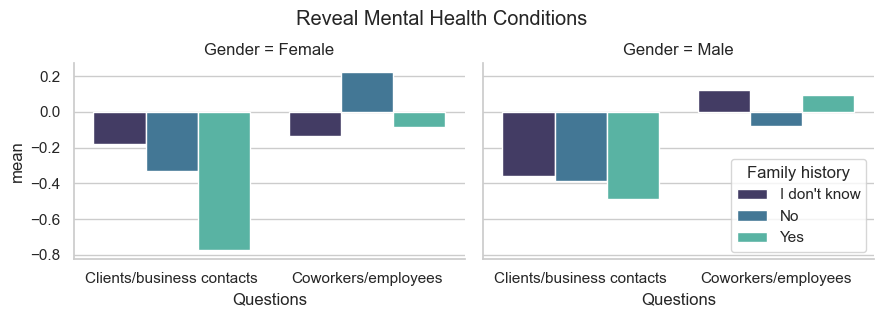

In [56]:
g = sns.FacetGrid(revealing, col="Gender", aspect=1.5)
g.map_dataframe(sns.barplot, x="Questions", y="mean",
                hue='Family history', palette='mako')

g.fig.suptitle("Reveal Mental Health Conditions", y=1.05)

plt.legend(title="Family history");

<h2>Specific Mental Health Conditions</h2>

* Males are more diagnosed and believe to have more mental health conditions than Females
* People with Family history expect/believe to have mental health conditions, without diagnoses

In [57]:
mental_health_conditions = curated_answer[((curated_answer['Believed_conditions'] != 0.0) | (curated_answer['Diagnosed_conditions'] != 0.0))
                                          & ((~curated_answer['Believed_conditions'].isna()) | (~curated_answer['Diagnosed_conditions'].isna()))
                                          ][['Believed_conditions', 'Diagnosed_conditions', 'Gender', 'Family history']]

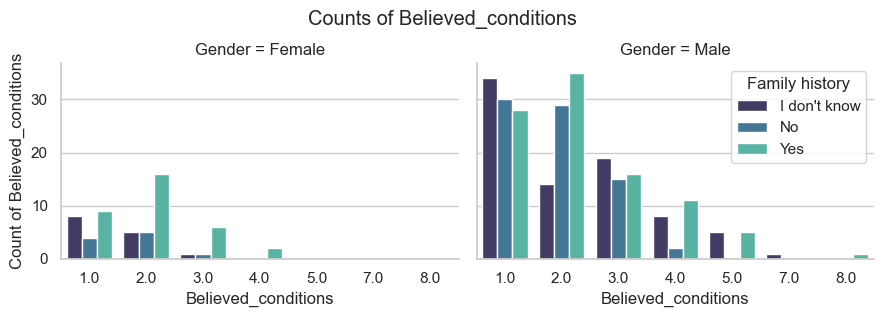

In [58]:
def condition_count(df, feature):
    df_changed = df.groupby(['Gender', 'Family history', feature])[feature].count(
    ).to_frame().rename(columns={feature: f'Count of {feature}'}).reset_index()

    g = sns.FacetGrid(
        df_changed[df_changed[feature] != 0.0], col="Gender", aspect=1.5)
    g.map_dataframe(sns.barplot, x=feature,
                    y=f'Count of {feature}', hue='Family history', palette='mako')
    plt.legend(title="Family history", loc='upper right')
    g.fig.suptitle(f"Counts of {feature}", y=1.05)


condition_count(mental_health_conditions, 'Believed_conditions');

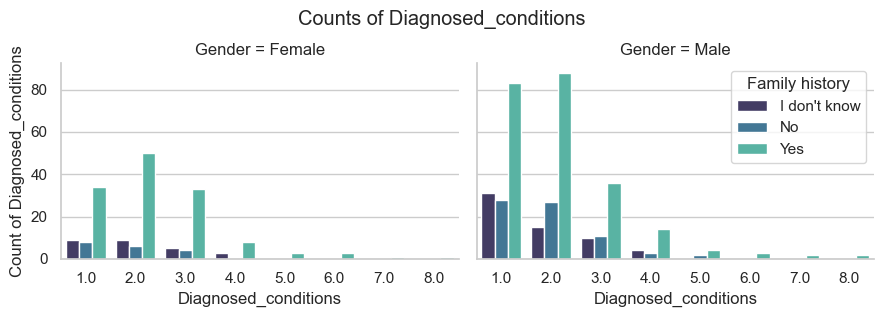

In [59]:
condition_count(mental_health_conditions, 'Diagnosed_conditions');

Male and Female specific mental health conditions - No gender specific diagnoses

Female Specific diagnosis

In [60]:
answer[answer['Questionid'].isin([115]) & answer['Userid'].isin(mental_health_conditions[mental_health_conditions['Gender']
                                                                                         == 'Female'].index) & ~answer['Answertext'].isna()].groupby('Answertext')['Answertext'].count().sort_values(ascending=False)

Answertext
Mood-Related                                138
Attention Deficit Hyperactivity              27
Stress-Related                               21
Substance-Related                             9
Obsessive-Compulsive Disorder                 8
Eating Disorder (Anorexia, Bulimia, etc)      7
Autism Spectrum                               2
Dissociative                                  1
Intimate Disorder                             1
Name: Answertext, dtype: int64

Male Specific

In [61]:
answer[answer['Questionid'].isin([115]) & answer['Userid'].isin(mental_health_conditions[mental_health_conditions['Gender']
                                                                                         == 'Male'].index) & ~answer['Answertext'].isna()].groupby('Answertext')['Answertext'].count().sort_values(ascending=False)

Answertext
Mood-Related                                                347
Stress-Related                                               47
Attention Deficit Hyperactivity                              45
Substance-Related                                            38
Obsessive-Compulsive Disorder                                15
Eating Disorder (Anorexia, Bulimia, etc)                     10
Autism Spectrum                                               4
Dissociative                                                  4
Gender Dysphoria                                              2
Neurological and Sleep                                        2
Psychotic Disorder (Schizophrenia, Schizoaffective, etc)      2
Name: Answertext, dtype: int64

<h1>Conclusions</h1>

* The survey focused on White males and Females, with the average age of 33.8 years (variance of 17 – 74 years), who live in the Western world. The Job profiles mostly were Front-End and Back-End developer, of which 14% through both genders were freelancers.
* Due to low availability of data, race was not added to the analysis.
* People report having mental health issues but less so in the present. 51% males and 58% females were have a formal diagnosis from mental health professional.
* Both genders experience mental health issues are hindering their work performance, when condition is not treated right, but don’t experience hindrance when disorder is treated properly.
* Males suffer more from productivity issues
* Females are less likely to let a client know they have issues.
* No gender specific diagnoses were found. 

Future outlook:
* A wider range of genders, ages and job profiles, as well as ethnic groups could give a better understanding of mental health in the whole industry. Current findings best represents white westerner’s developers in a corporate world.

What can be done?
* This survey shows that people with Family history are impacted much more when dealing with mental health issues. It's unclear if this is due to fear/anticipation from memories of childhood or if the conditions past down genetically are more severe. Additional support could be offered to such people, as they excel in Performance and overall impact issue, despite the genders. 
* Females would strongly not disclose mental health information to business contacts and this could indicate an underlying fear of sexism when presented as weak.